# Pipeline

In [6]:
from milvus import default_server

# stop running servers
default_server.stop()

# run the server
default_server.start()

I0000 00:00:1736422116.493574  395453 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [7]:
# Connect to Milvus
import milvus
client = milvus.MilvusServer(host="localhost", port=default_server.listen_port)

In [9]:
from pymilvus import connections, utility

# Connect to Milvus
connections.connect(
    host='localhost', 
    port=str(default_server.listen_port)  # Convert port to string and use the correct port
)

# List all collections
collections = utility.list_collections()
print("Available collections:", collections)

Available collections: ['emb']


In [21]:
from pymilvus import Collection, FieldSchema, CollectionSchema, DataType

# Define the collection schema
dim = 1024  # Dimension of your embeddings from snowflake-arctic-embed2
fields = [
    FieldSchema(name="id", dtype=DataType.VARCHAR, is_primary=True, max_length=100),
    FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=65535),
    FieldSchema(name="vec", dtype=DataType.FLOAT_VECTOR, dim=dim)
]
schema = CollectionSchema(fields=fields, description="Text embeddings collection")

# Create the collection
collection = Collection(name="emb", schema=schema)

# Create an IVF_FLAT index for the vector field
index_params = {
    "metric_type": "IP",  # IP for inner product (cosine similarity with normalized vectors)
    "index_type": "IVF_FLAT",
    "params": {"nlist": 1024}
}
collection.create_index(field_name="vec", index_params=index_params)

# Now you can load the collection
collection.load()

In [18]:
import json
import glob
import numpy as np
from tqdm import tqdm

def load_embeddings_and_texts(embeddings_path="embeddings/", docs_path="md_docs/"):
    # Get all markdown files in the docs folder
    md_files = glob.glob(f"{docs_path}/*.md")
    
    all_ids = []
    all_vectors = []
    all_texts = []
    
    # Track which JSON file we're currently reading to avoid reopening
    current_json = None
    json_data = None
    
    # Load each markdown file
    for md_file in tqdm(md_files, desc="Loading markdown files"):
        # Extract document ID from filename
        doc_id = md_file.split('/')[-1].replace('.md', '')
        
        # Read the markdown content
        with open(md_file, 'r', encoding='utf-8') as f:
            text_content = f.read()
            
        # Determine which JSON file should contain this embedding
        json_file = f"{embeddings_path}/{doc_id}.json"
        try:
            with open(json_file, 'r') as f:
                vector = json.load(f)[doc_id]
                
            all_ids.append(doc_id)
            all_vectors.append(vector)
            all_texts.append(text_content)
        except FileNotFoundError:
            print(f"Warning: No embedding found for {doc_id}")
            continue
    
    return all_ids, all_texts, all_vectors

# Load the embeddings and texts
doc_ids, texts, vectors = load_embeddings_and_texts()

# Prepare data for insertion
entities = [
    doc_ids,    # id field
    texts,      # text field
    vectors     # vector field
]

# Insert in batches
batch_size = 1000
num_entities = len(doc_ids)
for i in tqdm(range(0, num_entities, batch_size), desc="Inserting into Milvus"):
    end_idx = min(i + batch_size, num_entities)
    batch_entities = [
        entities[0][i:end_idx],
        entities[1][i:end_idx],
        entities[2][i:end_idx]
    ]
    collection.insert(batch_entities)

# After insertion, call flush to ensure data is persisted
collection.flush()

Loading JSON files: 100%|██████████| 12/12 [00:00<00:00, 160.75it/s]


Inserting into Milvus: 100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


In [4]:
from pymilvus import Collection, connections
connections.connect(host='localhost', port='19530')

collection = Collection("emb")      # Use your collection name
collection.load()

In [5]:
import ollama

# Initialize Ollama client
ollama_client = ollama.Client()

# First pull the model (run this once)
# ollama pull granite-embedding:278m # For multilingual support, 278M parameters

# Sample text to generate embeddings for
text = "Dil: Türkçe \n vekalet davası"

# Generate embeddings
response = ollama_client.embeddings(
    model="snowflake-arctic-embed2",
    prompt=text
)

# Get the embedding vector
embedding = response["embedding"]
print(embedding)

[0.20305965840816498, 0.12581247091293335, 0.8033919334411621, -0.24402393400669098, -0.5199522376060486, 0.8496984839439392, 0.7416032552719116, 0.705244243144989, -0.27013954520225525, -0.2018594741821289, 0.10375106334686279, 0.05880149081349373, 0.45693498849868774, 0.4003486633300781, -0.5047842860221863, 0.053973834961652756, 0.15520387887954712, -0.47712841629981995, -0.2432238757610321, 0.20354612171649933, -0.3686680495738983, 0.688578188419342, 0.3544732928276062, 0.20261694490909576, 0.6357718706130981, -0.06529845297336578, 0.9018096327781677, -0.9827708005905151, 0.29069867730140686, -0.5456866025924683, 0.24995099008083344, 0.32623744010925293, 0.20392835140228271, -0.8643518090248108, -0.5970615148544312, 0.10078484565019608, -0.4011581242084503, -0.19276243448257446, -1.1286107301712036, 0.7360434532165527, 0.6611369848251343, 0.4667975902557373, -0.3073931336402893, 0.18986134231090546, 0.16873982548713684, -0.7082410454750061, -0.04844426363706589, -1.4281902313232422

In [10]:
import numpy as np

query_vector = np.array(embedding)
query_vector = np.array(query_vector) / np.linalg.norm(query_vector)

search_params = {
    "metric_type": "IP",           # IP for normalized vectors (cosine similarity)
    "params": {"nprobe": 10}       # Number of clusters to search
}

# measure time precisely
import time
start_time = time.perf_counter_ns()
res = collection.search(
	data=[query_vector.tolist()],           # List of vectors to search for
	anns_field="vec",              # Vector field name
	param=search_params,
	limit=5,                   # Number of results to return
	output_fields=["id", "text"]   # Additional fields to return
)
end_time = time.perf_counter_ns()
print(f"Time taken: {(end_time - start_time) / 1_000_000:.2f} milliseconds")  # Convert ns to ms

Time taken: 7.25 milliseconds


In [41]:
def test_query_timing(query_text, num_runs=10000, limit=5):
    """
    Test Milvus query timing with multiple runs
    
    Args:
        query_text (str): Text to query
        num_runs (int): Number of timing runs to perform
        limit (int): Number of results to return per query
        
    Returns:
        dict: Timing statistics (mean, std, min, max)
    """
    # Generate embedding for query text
    response = ollama_client.embeddings(
        model="snowflake-arctic-embed2",
        prompt=query_text
    )
    query_vector = np.array(response["embedding"])
    query_vector = query_vector / np.linalg.norm(query_vector)
    
    search_params = {
        "metric_type": "IP",
        "params": {"nprobe": 512}
    }
    
    # Run multiple timing tests
    times = []
    for _ in range(num_runs):
        start_time = time.perf_counter_ns()
        collection.search(
            data=[query_vector.tolist()],
            anns_field="vec",
            param=search_params,
            limit=limit,
            output_fields=["id", "text"]
        )
        end_time = time.perf_counter_ns()
        times.append((end_time - start_time) / 1_000_000)  # Convert to ms
    
    # Calculate statistics
    times = np.array(times)
    stats = {
        "mean_ms": np.mean(times),
        "std_ms": np.std(times),
        "min_ms": np.min(times),
        "max_ms": np.max(times)
    }
    
    return stats

# Example usage:
test_text = "Dil: Türkçe \n vekalet davası"
stats = test_query_timing(test_text)
print(f"Query timing statistics (ms):")
print(f"Mean: {stats['mean_ms']:.2f} ± {stats['std_ms']:.2f}")
print(f"Range: [{stats['min_ms']:.2f}, {stats['max_ms']:.2f}]")

Query timing statistics (ms):
Mean: 1.22 ± 0.16
Range: [0.98, 3.32]


In [14]:
# Example usage:
test_text = "Dil: Türkçe \n hırsızlık davası"
stats = test_query_timing(test_text)
print(f"Query timing statistics (ms):")
print(f"Mean: {stats['mean_ms']:.2f} ± {stats['std_ms']:.2f}")
print(f"Range: [{stats['min_ms']:.2f}, {stats['max_ms']:.2f}]")

Query timing statistics (ms):
Mean: 1.55 ± 0.82
Range: [1.20, 8.95]


In [34]:
def test_query_timing(query_text, num_runs=10000, limit=5):
    """
    Test NumPy computation timing with multiple runs
    
    Args:
        query_text (str): Text to query
        num_runs (int): Number of timing runs to perform
        limit (int): Number of results to return per query
        
    Returns:
        dict: Timing statistics for both Milvus and NumPy operations
    """
    # Generate embedding for query text (done once)
    response = ollama_client.embeddings(
        model="snowflake-arctic-embed2",
        prompt=query_text
    )
    query_vector = np.array(response["embedding"])
    query_vector = query_vector / np.linalg.norm(query_vector)

    
    # Get all vectors from collection for NumPy comparison
    all_vectors = collection.query(
        expr="id != ''",
        output_fields=["id", "text", "vec"]
    )
    vectors_matrix = np.array([item['vec'] for item in all_vectors])
    
    # Run multiple timing tests
    numpy_times = []
    
    for _ in range(num_runs):
        # Test NumPy timing
        start_time = time.perf_counter_ns()
        similarities = np.dot(vectors_matrix, query_vector)
        top_k_indices = np.argpartition(similarities, -limit)[-limit:]
        top_k_indices = top_k_indices[np.argsort(-similarities[top_k_indices])]
        end_time = time.perf_counter_ns()
        numpy_times.append((end_time - start_time) / 1_000_000)  # Convert to ms
    
    # Calculate statistics
    numpy_times = np.array(numpy_times)
    
    stats = {
        "numpy": {
            "mean_ms": np.mean(numpy_times),
            "std_ms": np.std(numpy_times),
            "min_ms": np.min(numpy_times),
            "max_ms": np.max(numpy_times)
        }
    }
    
    return stats

# Example usage:
test_text = "Dil: Türkçe \n vekalet davası"
stats = test_query_timing(test_text)

print("\nNumPy computation timing statistics (ms):")
print(f"Mean: {stats['numpy']['mean_ms']:.2f} ± {stats['numpy']['std_ms']:.2f}")
print(f"Range: [{stats['numpy']['min_ms']:.2f}, {stats['numpy']['max_ms']:.2f}]")


NumPy computation timing statistics (ms):
Mean: 1.07 ± 1.44
Range: [0.48, 70.09]


In [37]:
print(res[0][0].entity.entity.text)



T.C.
İSTANBUL
10. ASLİYE TİCARET MAHKEMESİ

ESAS NO:2023/704 Esas
KARAR NO :2024/341

DAVA:İtirazın İptali
DAVA TARİHİ:03/11/2023
KARAR TARİHİ:30/04/2024

Mahkememizde görülmekte olan İtirazın İptali davasının yapılan açık yargılaması sonunda;
GEREĞİ DÜŞÜNÜLDÜ:
DAVA: Davacı vekili dava dilekçesinde özetle; davalılar ... ... A.Ş. Ve ... ... .... A.Ş. tarafından 23/04/2022 tarihinde ... İşletme Müdürlüğü sorumluluk sahasında bulunan ... İlçesi, İstiklal Mahallesi,577 Sokak, No:8 adresinde yapılan çalışma esnasında davalı tarafça gereken dikkat ve özenin gösterilmemiş olması sebebiyle davacı şirketin enerji dağıtım altyapısına dahil olan kablo ve tesisata hasar verildiğinin tespit edildiğini, davalıların ... ... A.Ş. Ve ... ... İnşaat Nakliye Temizlik İthalat Ve Sanayi Tic. A.Ş. tarafından hasardan doğan bedellerinin ödenmemesi üzerine borçlu aleyhine, hasar tarihinden takip tarihine kadar işlemiş faiz dahil 3.683,62-TL'nin tahsili amacıyla ilamsız icra takibi başlatılmış ve borçluya Ör

In [ ]:
print(res[0][1].entity.text)

In [ ]:
collection.delete("where id != ''")

# DEMO

In [1]:

from milvus import default_server
from pymilvus import Collection, connections
import milvus
from pymilvus import connections, utility

# stop running servers
default_server.stop()

# run the server
default_server.start()


# Connect to Milvus
client = milvus.MilvusServer(host="localhost", port=default_server.listen_port)

# Connect to Milvus
connections.connect(host='localhost', port=str(default_server.listen_port))

# List all collections
collections = utility.list_collections()
print("Available collections:", collections)


connections.connect(host='localhost', port=str(default_server.listen_port))

collection = Collection("emb")
collection.load()

Available collections: ['emb']


In [10]:
# ollama
import ollama
import numpy as np

# Initialize Ollama client
ollama_client = ollama.Client()

def query_documents(query_text, limit=5):
    """
    Query documents using semantic search and print formatted results
    
    Args:
        query_text (str): Text to search for
        limit (int): Number of results to return
    """
    # Generate embeddings
    response = ollama_client.embeddings(
        model="snowflake-arctic-embed2",
        prompt=query_text
    )
    
    # Normalize the query vector
    query_vector = np.array(response["embedding"])
    query_vector = query_vector / np.linalg.norm(query_vector)
    
    # Search parameters
    search_params = {
        "metric_type": "IP",
        "params": {"nprobe": 10}
    }
    
    # Perform search
    results = collection.search(
        data=[query_vector.tolist()],
        anns_field="vec",
        param=search_params,
        limit=limit,
        output_fields=["id", "text"]
    )
    
    # Print results
    print(f"\nQuery: '{query_text}'\n")
    print("-" * 80)
    
    for i, hit in enumerate(results[0], 1):
        similarity = hit.distance
        doc_id = hit.entity.get('id')
        text = hit.entity.get('text')
        
        print(f"\nResult {i} (Similarity: {similarity:.3f})")
        print(f"Document ID: {doc_id}")
        print("-" * 40)
        print(text[:500] + "..." if len(text) > 500 else text)
        print("-" * 80)

# Example usage:
query_documents("itiraz")


Query: 'itiraz'

--------------------------------------------------------------------------------

Result 1 (Similarity: 6.418)
Document ID: 962039700
----------------------------------------


 T.C. ANKARA BÖLGE ADLİYE MAHKEMESİ BAM 22. HUKUK DAİRESİ Esas-Karar No: 2023/735 - 2023/1386

T.C.
A N K A R A
B Ö L G E A D L İ Y E M A H K E M E S İ
22. H U K U K D A İ R E S İ

ESAS NO : 2023/735 (ESASTAN RET )
KARAR NO : 2023/1386

T Ü R K M İ L L E T İ A D I N A
İ S T İ N A F K A R A R I

İNCELENEN KARARIN
MAHKEMESİ : ANKARA 11. ASLİYE TİCARET MAHKEMESİ
TARİHİ : 04/04/2023
ESAS-KARAR NO : 2022/733 E - 2023/250 K

DAVACI
VEKİLİ
DAVALI : HASIMSIZ
DAVANIN KONUSU : Kıymetli Evrak İptali
KARA...
--------------------------------------------------------------------------------

Result 2 (Similarity: 5.517)
Document ID: 914992500
----------------------------------------


T.C.
İSTANBUL
BÖLGE ADLİYE MAHKEMESİ
12. HUKUK DAİRESİ
DOSYA NO: 2023/1457
KARAR NO: 2023/1161
T Ü R K M İ L L E T İ A D I N A

# Plot

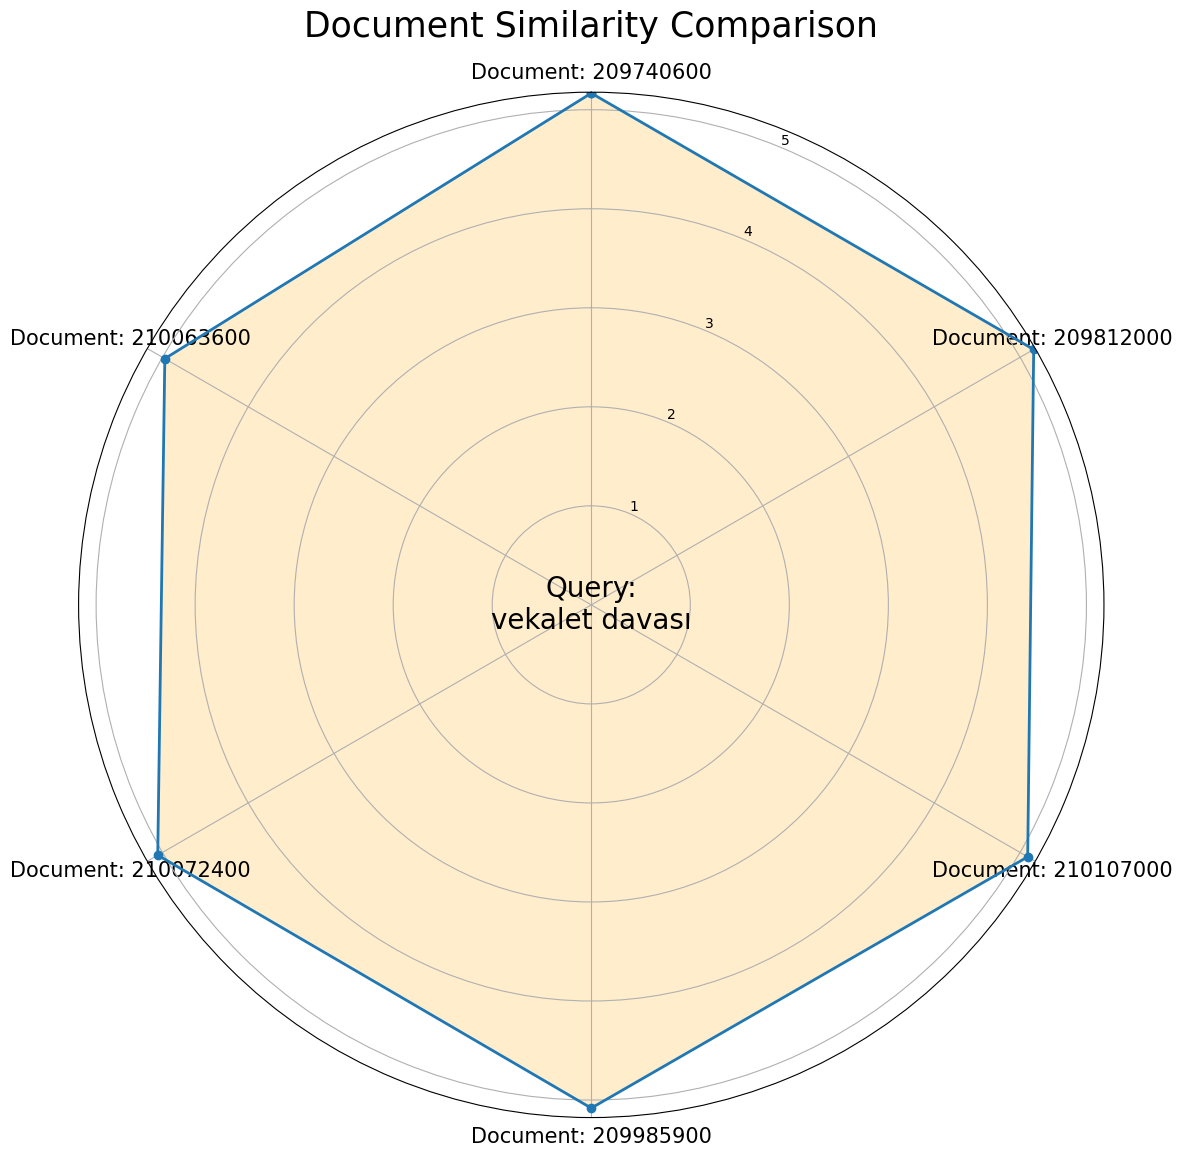

In [48]:
import matplotlib.pyplot as plt
import numpy as np
def plot_similarity_spider(query_results, query_text, title="Document Similarity Comparison"):
    # Extract similarities and document IDs
    similarities = [hit.distance for hit in query_results[0]]
    # Format labels with "Document: [ID]"
    labels = [f"Document: {hit.entity.get('id')}" for hit in query_results[0]]
    
    # Number of variables
    num_vars = len(similarities)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # complete the circle
    
    # Initialize the spider plot
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))
    
    # Plot data
    similarities += similarities[:1]  # complete the circle
    ax.plot(angles, similarities, 'o-', linewidth=2)
    ax.fill(angles, similarities, alpha=0.2, color='orange')
    
    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw axis lines for each angle and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, size=15)
    
    # Add title with padding
    plt.title(title, pad=40, size=25)
    
    # Add query text in the center
    ax.text(0, 0, f"Query:\n{query_text}", 
            ha='center', va='center', 
            wrap=True,
            size=20)
    
    # Adjust layout to prevent label overlap
    plt.tight_layout()
    plt.show()

# Use it with your search results
plot_similarity_spider(res, "vekalet davası")  # 'text' is your query text variable